In [33]:
import torch
import torchvision
import data_setup, engine

import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchinfo import summary

from data_setup import create_dataloaders
from helper_functions import set_seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
image_path = "data/pizza_steak_sushi/"
train_dir = image_path + "train"
test_dir = image_path + "test"

In [4]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [5]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir, 
                                                                    test_dir=test_dir,
                                                                    batch_size=BATCH_SIZE,
                                                                    transform=manual_transforms)

In [10]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

(-0.5, 223.5, 223.5, -0.5)

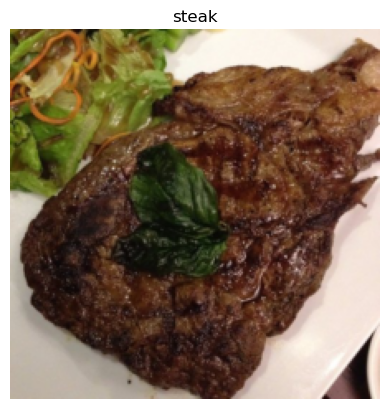

In [11]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [12]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)

In [13]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

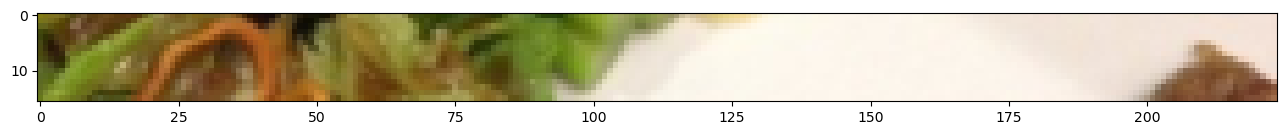

In [16]:
image_permuted = image.permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

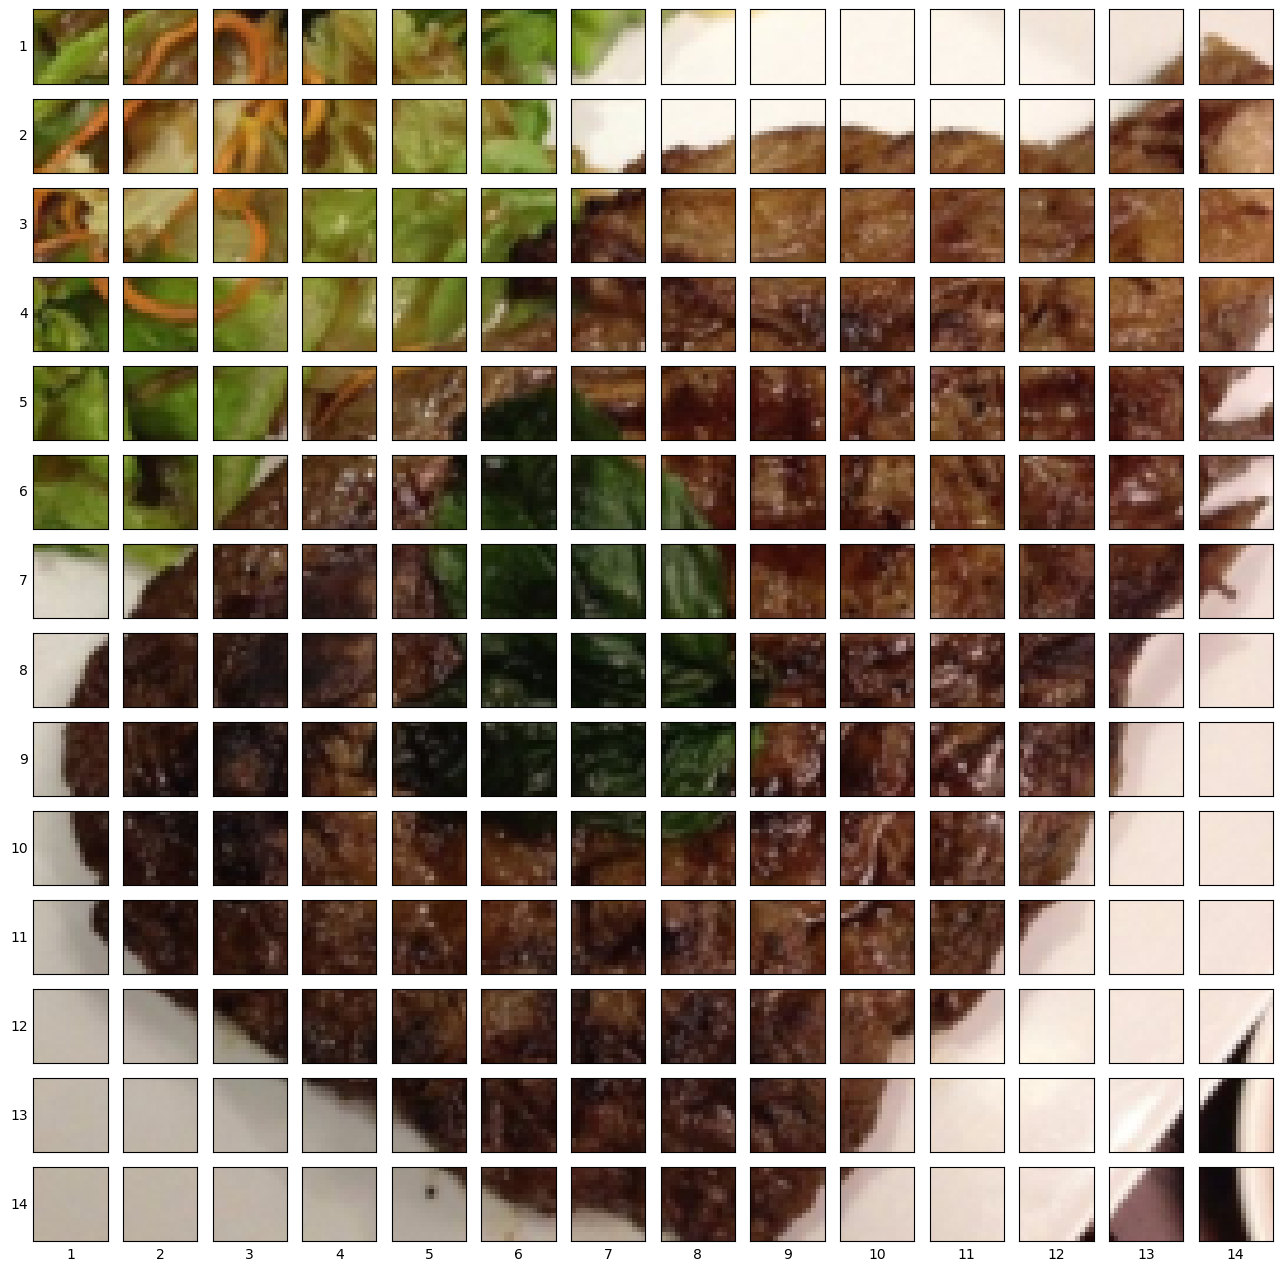

In [21]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "img_size must be divisible by patch_size"

fig, axs = plt.subplots(nrows= img_size // patch_size,
                        ncols= img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

for i, patch_height in enumerate(range(0,img_size,patch_size)):
    for j, patch_width in enumerate(range(0,img_size,patch_size)):
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size,:])
        axs[i,j].set_ylabel(i+1,
                            rotation="horizontal",
                            horizontalalignment="right",
                            verticalalignment="center")
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()
        
plt.show()
        

In [22]:
conv2d = nn.Conv2d(in_channels=3, 
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

In [24]:
image_out_of_conv = conv2d(image.unsqueeze(0))

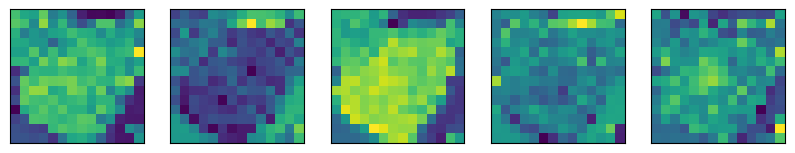

In [25]:
import random 
random_indexes = random.sample(range(0, 758), k=5)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,10))

for i, idx in enumerate(random_indexes):
    img_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(img_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [26]:
single_feature_map = image_out_of_conv[:, 0, :, :]

In [29]:
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

image_out_of_conv_flattened =  flatten_layer(image_out_of_conv)

In [30]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)

(-0.5, 195.5, 0.5, -0.5)

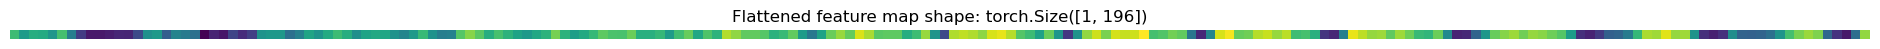

In [31]:
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

plt.figure(figsize=(24,24))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [36]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, "patch size must be divisible by patch size"
        
        x = self.patcher(x)
        x = self.flatten(x)
        
        return x.permute(0, 2, 1)
        

In [ ]:
set_seeds()

patch_size = 16

height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)

number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

patch_position_embedding = patch_embedding_class_token + position_embedding